# Hyperparameter Optimization

> Georgios Varnavides | Jan 12 2025  
>
> Sample: white-noise object  
> Sampling conditions:2 A^-1 max-scattering angle, Nyquist sampling  
> Imaging conditions: 1 A^-1 semiangle, 200 A defocus, 100 A stig

In addition to well-calibrated data, two important sets of hyperparameters affect the reconstuction quality in direct ptychography methods:
- Relative rotation between the detector coordinate system and the scan axes
- The probe aberrations (at the middle-plane of the sample)

These are often hard to know _a-priori_ so we must estimate them from the data. This notebook documents the 4 different ways to do so in `quantem`.
We use a simulated dataset with known aberrations and rotation_angle.

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import quantem as em
import numpy as np

/Users/gvarnavides/Documents/git-repos/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = em.core.io.load("../data/white-noise-object_defocus+stig.zip")
dataset

Dataset(shape=(96, 96, 96, 96), dtype=float64, name='4D-STEM dataset')
  sampling: [0.25       0.25       0.04166667 0.04166667]
  units: ['A', 'A', 'A^-1', 'A^-1']
  signal units: 'arb. units'

In [6]:
energy = 300e3
wavelength = em.core.utils.utils.electron_wavelength_angstrom(energy)
k_probe = 1
semiangle_cutoff = k_probe * wavelength * 1e3

# ground truth
known_aberration_coefs = {
    "C10": 200,
    "C12": 100,
    "phi12": np.deg2rad(11)
}
known_rotation_angle = np.deg2rad(-13)

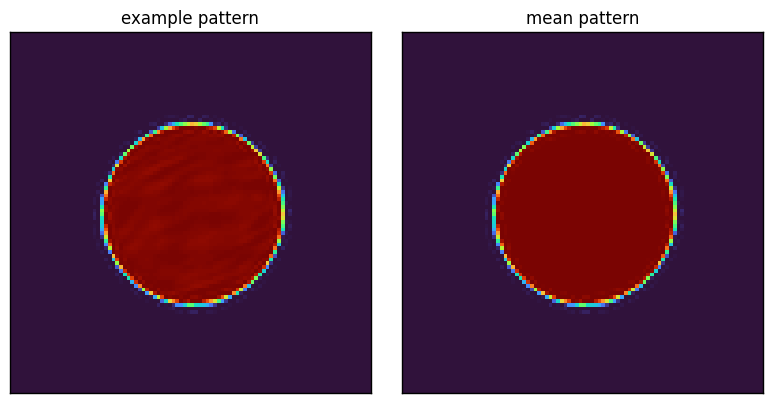

In [5]:
em.visualization.show_2d(
    [
        dataset[0,0].array,
        dataset.mean((0,1)),
    ],
    title=[
        "example pattern","mean pattern"
    ],
    power=0.5,
    cmap='turbo'
);

## Ground Truth Reconstruction

We start with the ground-truth reconstruction so you can see what we're aiming for

In [17]:
def visualize_recon_and_ctf(array):
    em.visualization.show_2d(
        [
            array,
            np.fft.fftshift(
                np.abs(
                    np.fft.fft2(
                        array
                    )
                )/2
            )
        ],
        axsize=(5,5),
        cbar=True,
        title=["white-noise reconstruction","contrast transfer function"],
    )

Reconstructing with:

 HyperparameterState(
  current_aberrations={'C10': 200.0, 'C12': 100.0, 'phi12': 0.19198621771937624},
  current_rotation_angle=np.float64(-0.22689280275926285),
)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1791/1791 [00:00<00:00, 2969.96it/s]


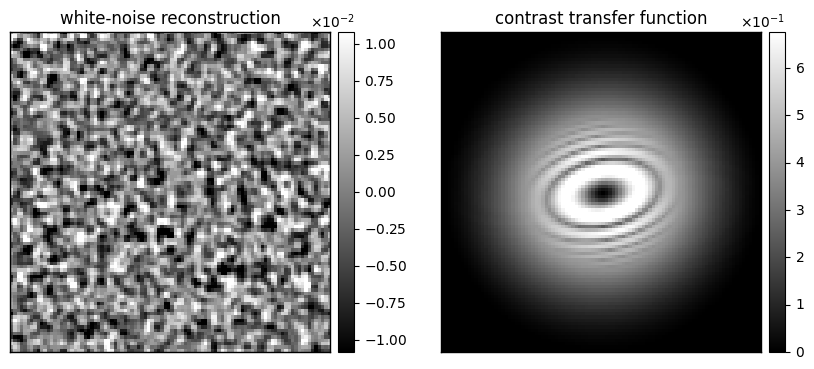

In [18]:
direct_ptycho_gt = em.diffractive_imaging.DirectPtychography.from_dataset4d(
    dataset,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    rotation_angle=known_rotation_angle,
    aberration_coefs=known_aberration_coefs,
    # device='gpu',
)

ssb_gt = direct_ptycho_gt.reconstruct().obj
visualize_recon_and_ctf(ssb_gt);

## Initial Guess Reconstruction

It's common to start with an initial estimate for the probe defocus, but not the higher-order aberrations or rotation angle.

Reconstructing with:

 HyperparameterState(
  current_aberrations={'C10': 100.0},
  current_rotation_angle=-0.13962634015954636,
)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1791/1791 [00:00<00:00, 7365.04it/s]


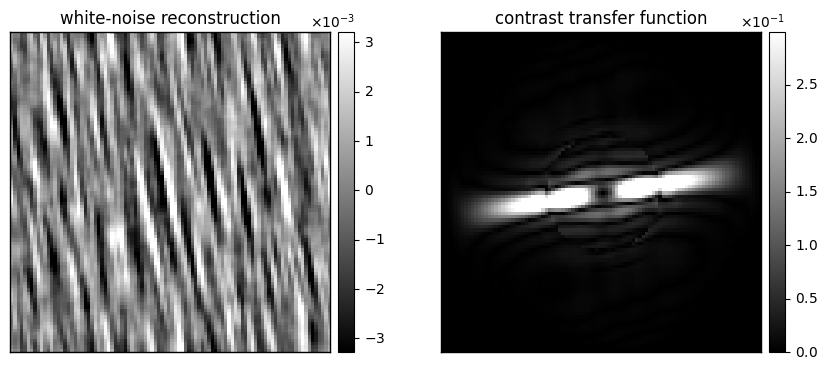

In [19]:
# initial guess
guess_aberration_coefs = {
    "C10": 100,
}
guess_rotation_angle = None

direct_ptycho = em.diffractive_imaging.DirectPtychography.from_dataset4d(
    dataset,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    rotation_angle=guess_rotation_angle,
    aberration_coefs=guess_aberration_coefs,
    # device='gpu',
)

ssb_guess = direct_ptycho.reconstruct().obj
visualize_recon_and_ctf(ssb_guess);

Notice a couple of things:
- The reconstruction quality is considerably worse
- The CTF is considerably more asymmetric
  - its two-fold symmetry points to the presence of astigmatism
 
You will also notice we print the current `HyperparameterState` for every reconstruction run to be explicit (you can disable this with `verbose=False`).
In-fact there's a `direct_ptycho.hyperparameter_state` attribute that stores the current HyperparameterState, let's inspect it.

In [16]:
direct_ptycho.hyperparameter_state

HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
)

Notice that even though we didn't specify a rotation angle guess, one was estimated during initialization (using the curl of the center-of-mass signal). This is 5 degrees off -- this is a lot!

In [28]:
com_curl_rotation_deg = np.rad2deg(
    direct_ptycho.hyperparameter_state.initial_rotation_angle
    # direct_ptycho.rotation_angle # property which fetches the current rotation_angle
)
known_rotation_angle_deg = np.rad2deg(known_rotation_angle)

print(f"estimated rotation angle {com_curl_rotation_deg!s}")
print(f"known rotation angle {known_rotation_angle_deg!s}")

estimated rotation angle -8.0
known rotation angle -13.0


## Overriding initial aberrations

We can override these at runtime during reconstruction. This can be useful in quickly exploring some values:

Reconstructing with:

 HyperparameterState(
  current_aberrations={'C10': 0.0},
  current_rotation_angle=0.0,
)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1791/1791 [00:00<00:00, 6073.53it/s]


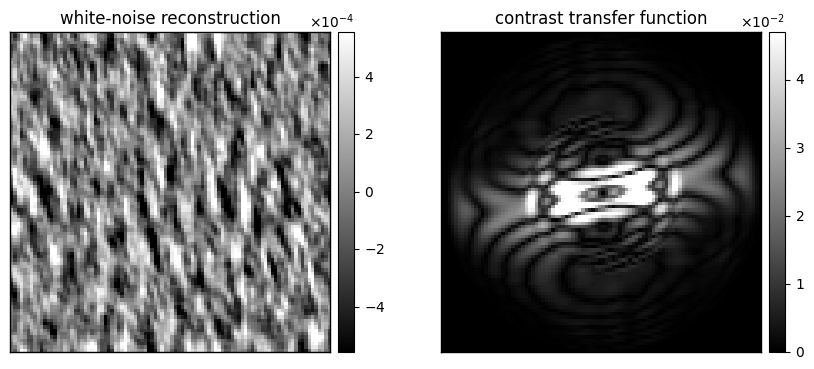

In [29]:
ssb_guess = direct_ptycho.reconstruct(
    override_aberration_coefs={"C10":0},
    override_rotation_angle=0.0,
).obj
visualize_recon_and_ctf(ssb_guess);

Importantly, this performs the reconstruction using the specified overrides but does not modify the stored state:

In [30]:
direct_ptycho.hyperparameter_state

HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
)

It's also important to note this _overrides_ stored values, and does not explicitly set the aberration coefficients. I.e. the following will use the initial C10 and only override C12 (which was implicitly initialized as zero):

Reconstructing with:

 HyperparameterState(
  current_aberrations={'C10': 100.0, 'C12': 100.0},
  current_rotation_angle=-0.13962634015954636,
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1791/1791 [00:00<00:00, 10289.45it/s]


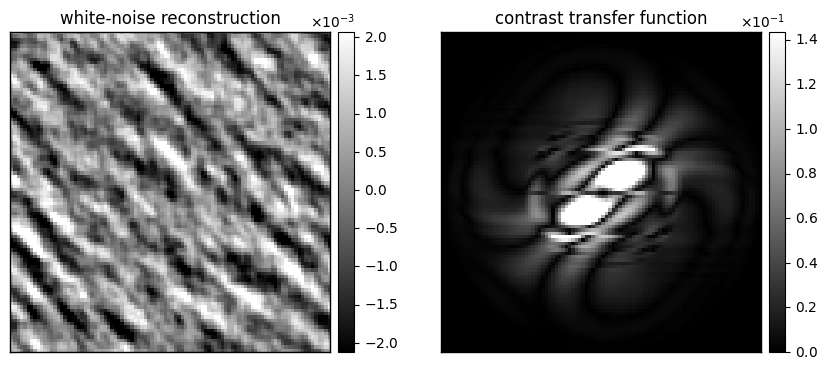

In [32]:
ssb_guess = direct_ptycho.reconstruct(
    override_aberration_coefs={"C12":100},
).obj
visualize_recon_and_ctf(ssb_guess);

## Grid-search optimization

The simplest type of optimization is to scan through a grid of values, selecting one based on a calculated metric (in our case, the variance across the aligned BF stack).

We'll use an `OptimizationParameter` class to indicate which parameters we want to optimize and their range.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.76it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 100.0, 'C12': np.float64(0.0), 'phi12': np.float64(-1.5707963267948966)},
)


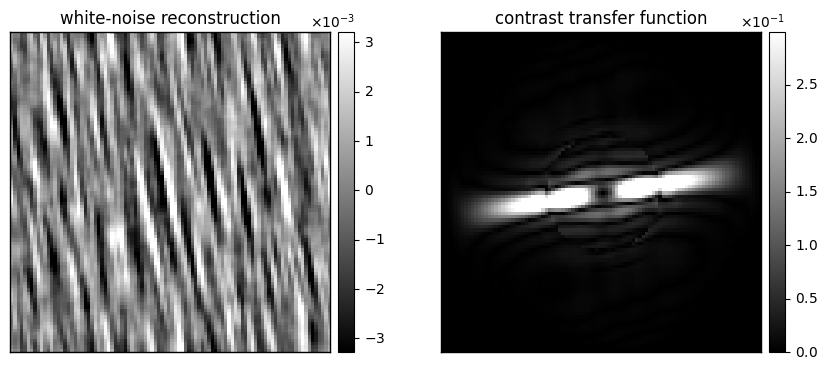

In [91]:
from quantem.diffractive_imaging.direct_ptychography import OptimizationParameter

direct_ptycho = direct_ptycho.grid_search_hyperparameters(
    aberration_coefs={
        "C12":OptimizationParameter(0,200,n_points=3),
        "phi12":OptimizationParameter(-np.pi/2,np.pi/2,n_points=3)
    },
    deconvolution_kernel='parallax', # faster with prlx
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

So we asked it to evaluate the loss function using 3 equispaced points for C12 (b/w 0-500) and phi12 (b/w -90 and 90 degrees).

The results are stored in `direct_ptycho._grid_search_results` and we can inspect them with a small utility function:

In [92]:
def tabular_print(tabular_data):
    headers = list(tabular_data[0][0].keys()) + ["loss"]
    header_row = "".join([f"{h:^15}" for h in headers])

    print(header_row)
    print("-" * len(header_row))

    for entry, loss in tabular_data:
        dic = entry.copy()
        dic["loss"] = loss
        print("".join([f"{dic[h]:>15.4e}" for h in headers]))

tabular_print(direct_ptycho._grid_search_results)

      C12           phi12          loss      
---------------------------------------------
     0.0000e+00    -1.5708e+00     1.1785e-11
     0.0000e+00     0.0000e+00     1.1785e-11
     0.0000e+00     1.5708e+00     1.1785e-11
     1.0000e+02    -1.5708e+00     1.2037e-11
     1.0000e+02     0.0000e+00     1.1877e-11
     1.0000e+02     1.5708e+00     1.2037e-11
     2.0000e+02    -1.5708e+00     1.2297e-11
     2.0000e+02     0.0000e+00     1.1897e-11
     2.0000e+02     1.5708e+00     1.2297e-11


The one with the lowest loss function is chosen and stored in the `HyperparameterState`:

In [93]:
direct_ptycho.hyperparameter_state

HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 100.0, 'C12': np.float64(0.0), 'phi12': np.float64(-1.5707963267948966)},
)

You'll notice it also used the initial C10 aberration. You can also specifically override some aberrations while optimizing others:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.70it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 200.0, 'C12': np.float64(100.0), 'phi12': np.float64(0.0)},
)


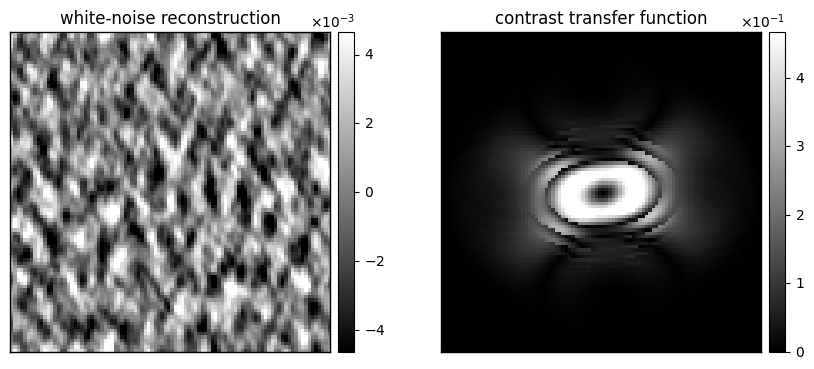

In [94]:
direct_ptycho = direct_ptycho.grid_search_hyperparameters(
    aberration_coefs={
        "C10":200,
        "C12":OptimizationParameter(0,200,n_points=3),
        "phi12":OptimizationParameter(-np.pi/2,np.pi/2,n_points=3)
    },
    deconvolution_kernel='parallax', # faster with prlx
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

## Bayesian Optimization 

We can go further, by sampling candidate points more effectively using Bayesian priors. To do this, we rely on the `optuna` package.

The syntax is very similar with above, but note we don't need to specify the `n_points` argument to `OptimizationParameter`, and instead we use a global `n_trials` parameter. As a rule-of thumb I often use ~50 trials per parameter I'm optimizing

Best trial: 242. Best value: 6.7851e-12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:06<00:00,  3.76it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 197.99104204304734, 'C12': 102.96831578024656, 'phi12': 0.15885669268175578},
  optimized_rotation_angle=-0.24132069800310257,
)


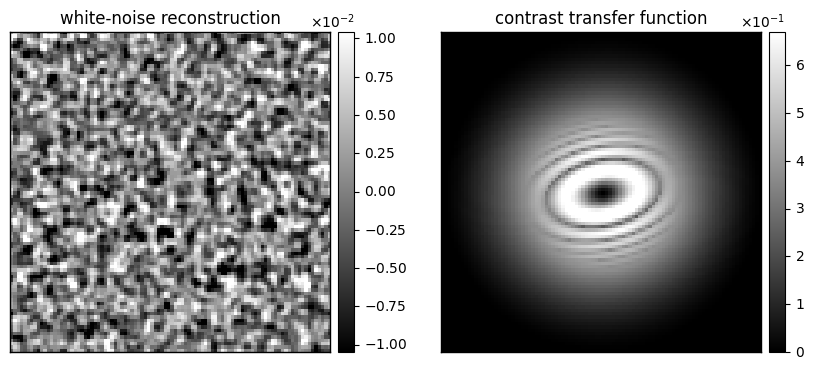

In [98]:
# Optimize aberrations and rotation with optuna
direct_ptycho = direct_ptycho.optimize_hyperparameters(
    aberration_coefs={
        "C10":OptimizationParameter(0,500),
        "C12":OptimizationParameter(0,300),
        "phi12":OptimizationParameter(-np.pi/2,np.pi/2)
    },
    rotation_angle=OptimizationParameter(-0.5,0.5),
    n_trials=250,
    deconvolution_kernel='parallax',
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

You'll notice the optimization essentially recovered all the parameters correctly and the reconstruction is very close to our ground-truth one!

Note that `reconstruct` by default uses the optimized values stored in the current HyperparameterState (potentially overridden with specified ones at runtime).
If you want to use the initial parameters instead, you can pass `use_initial_state=True`:

Reconstructing with:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1791/1791 [00:00<00:00, 9728.04it/s]


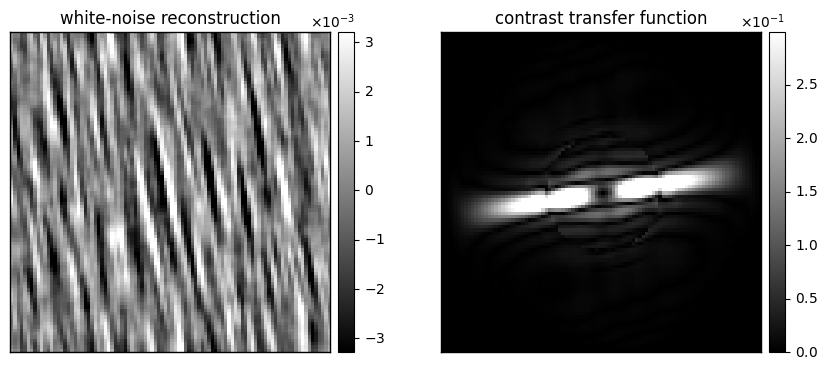

In [99]:
ssb_guess = direct_ptycho.reconstruct(
    use_initial_state=True
).obj
visualize_recon_and_ctf(ssb_guess);

You can also manually modify / clear `HyperparameterState`, though we don't recommend this:

In [105]:
state_copy_to_modify = direct_ptycho.hyperparameter_state.copy()
print(state_copy_to_modify)

print("\nClear optimized values:")
state_copy_to_modify.clear_optimized()
print(state_copy_to_modify)

print("\nManually specify values:")
state_copy_to_modify.optimized_aberrations["C10"] = -37
print(state_copy_to_modify)

HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 197.99104204304734, 'C12': 102.96831578024656, 'phi12': 0.15885669268175578},
  optimized_rotation_angle=-0.24132069800310257,
)

Clear optimized values:
HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
)

Manually specify values:
HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': -37},
)


## Least Squares Fitting

We also provide two ways to fit the aberration coefficients from the data using least-squares.

### Cross - Correlation
The first uses cross-correlation to measure the lateral virtual BF image shifts and correlate them with the gradients of a low-order aberration surface.

Note this only gives access to C10, C12, phi12, and rotation_angle.

Aligning (reference): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': -27.31063461303711, 'C12': 26.963638305664062, 'phi12': -0.2502831518650055},
  optimized_rotation_angle=-0.7228701114654541,
)


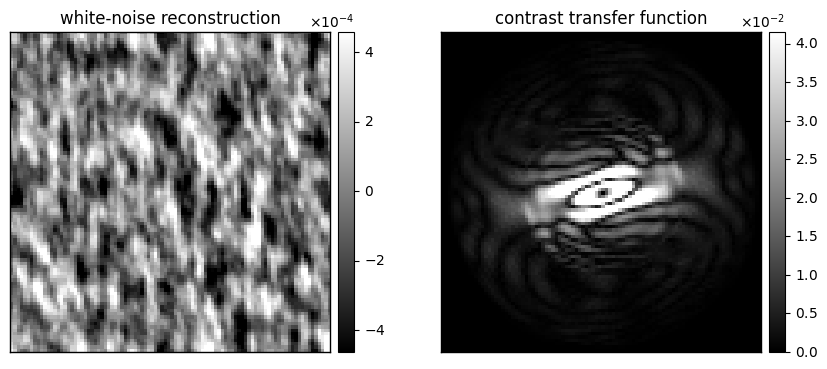

In [119]:
# reference fit from no guess 
direct_ptycho = direct_ptycho.fit_hyperparameters_cross_correlation(
    alignment_method='reference',
    bin_factors=(1,),

    aberration_coefs = {"C10":0,"C12":0,"phi12":0}, # manually specify zero guess
    rotation_angle= 0, # manually specify zero guess
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

In order to align the virtual BF images with cross-correlation, we require a  reference reconstruction.
To do this, we perform a reconstruction with the current `HyperparameterState`.
To showcase this here, we explicitly override these to 0, in-practice you would probably use the optimized or initial state.

It didn't do a great job. We have a couple of knobs to make this better:
- We can bin the virtual BFs in order to increase SNR before cross-correlation

Aligning (reference): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 94.43489074707031, 'C12': 46.00366973876953, 'phi12': 0.34927159547805786},
  optimized_rotation_angle=-0.50180983543396,
)


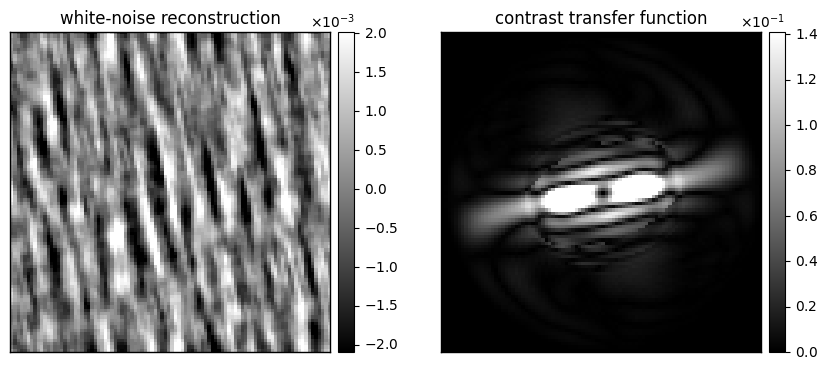

In [113]:
# reference fit from no guess 
direct_ptycho = direct_ptycho.fit_hyperparameters_cross_correlation(
    alignment_method='reference',
    bin_factors=(2,),

    aberration_coefs = {"C10":0,"C12":0,"phi12":0}, # manually specify zero guess
    rotation_angle= 0, # manually specify zero guess
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

This is indeed better, but ultimately the best knob is to iteratively refine the reference by performing another reconstruction with the optimized values. This can be combined with binning as follows:

Aligning (reference): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 190.7965087890625, 'C12': 97.47371673583984, 'phi12': 0.16502520442008972},
  optimized_rotation_angle=-0.1979220062494278,
)


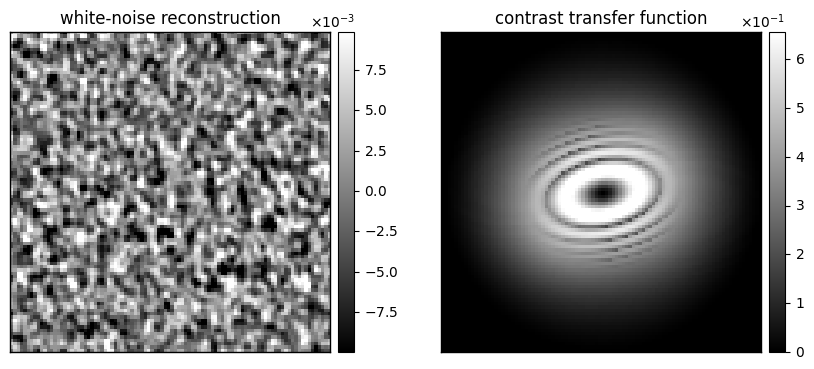

In [118]:
# reference fit from no guess 
direct_ptycho = direct_ptycho.fit_hyperparameters_cross_correlation(
    alignment_method='reference',
    bin_factors=(1,1,1,), # (3,2,1) etc also works
    aberration_coefs = {"C10":0,"C12":0,"phi12":0}, # manually specify zero guess
    rotation_angle= 0, # manually specify zero guess
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

In-fact, we don't need a reference at all! Using `alignment_method='pairwise'` we can instead build a self-consistent linear system using pairwise cross-correlations and solve that instead!

This sounds neat, and in this case works well, but not well-tested in practice so use at your own risk!

Aligning (pairwise): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 191.0621795654297, 'C12': 95.01526641845703, 'phi12': 0.14684058725833893},
  optimized_rotation_angle=-0.17955243587493896,
)


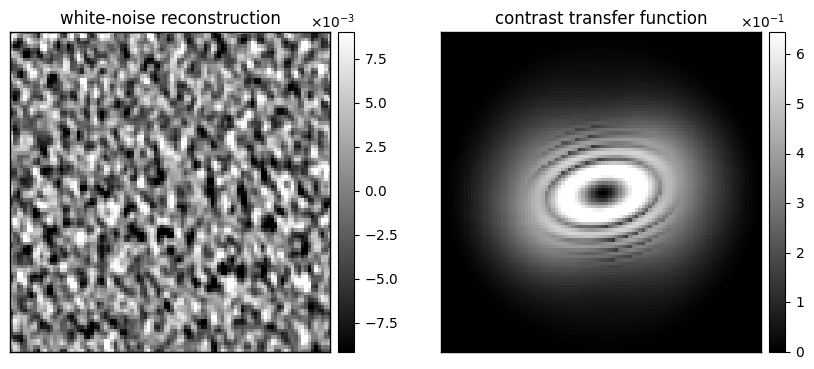

In [123]:
# fit without a reference
direct_ptycho = direct_ptycho.fit_hyperparameters_cross_correlation(
    alignment_method='pairwise',
    bin_factors=(1,),
    aberration_coefs = {"C10":0,"C12":0,"phi12":0}, # manually specify zero guess
    rotation_angle= 0, # manually specify zero guess
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

### Aperture Overlap Fitting

Finally, we can directly fit the aperture overlap ("Gamma") functions against a basis of aberration functions.

Fitting aberrations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53order/s, ['C10', 'C12_a', 'C12_b']]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 104.68291473388672, 'C12': 94.54666900634766, 'phi12': 0.14563162624835968},
)


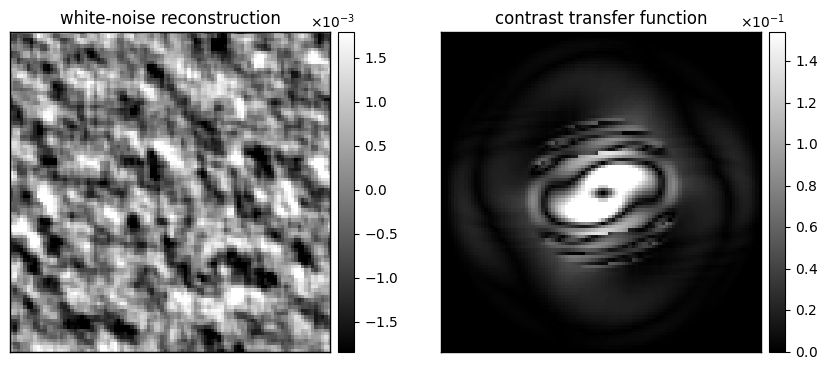

In [126]:
# least squares fit from no guess
direct_ptycho = direct_ptycho.fit_hyperparameters_least_squares(
    aberration_coefs = {"C10":0,"C12":0,"phi12":0}, # no prior guess
    cartesian_basis=["C10","C12_a","C12_b"],
    verbose=True,
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

This also didn't work very well, but there's a number of knobs we can use:
- `q_signal_weight` and `num_q_modes` control which and how many spatial frequencies will be used for the least-squares system.
  - For Nyquist-sampled datasets (like this one), we recommend `q_signal_weight` -> 0 (to prioritize frequencies near the semiangle cutoff)
  - For sub-sampled datasets, we recommend a larger number, say `q_signal_weight` -> 10 (to prioritize high signal power frequencies)

Fitting aberrations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69order/s, ['C10', 'C12_a', 'C12_b']]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 194.4795379638672, 'C12': 97.7030258178711, 'phi12': 0.22305315732955933},
)


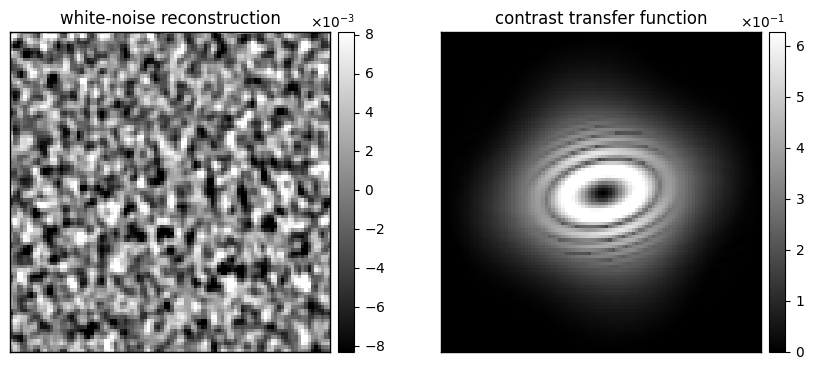

In [130]:
# least squares fit from no guess
direct_ptycho = direct_ptycho.fit_hyperparameters_least_squares(
    aberration_coefs = {"C10":0,"C12":0,"phi12":0}, # no prior guess
    cartesian_basis=["C10","C12_a","C12_b"],
    q_signal_weight=0.0,
    num_q_modes=12, # default is 6
    verbose=True,
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

This did the trick, but for posperity we can also perform this recursively by deconvolving our previous guess from the measured data (and thus only fitting the residuals):

Here we perform 4 rounds of optimization: C10-only for 3 rounds and then one round of C10, C12a, and C12b

Fitting aberrations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.59order/s, ['C10', 'C12_a', 'C12_b']]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 193.7550048828125, 'C12': 99.4912338256836, 'phi12': 0.14589424431324005},
)


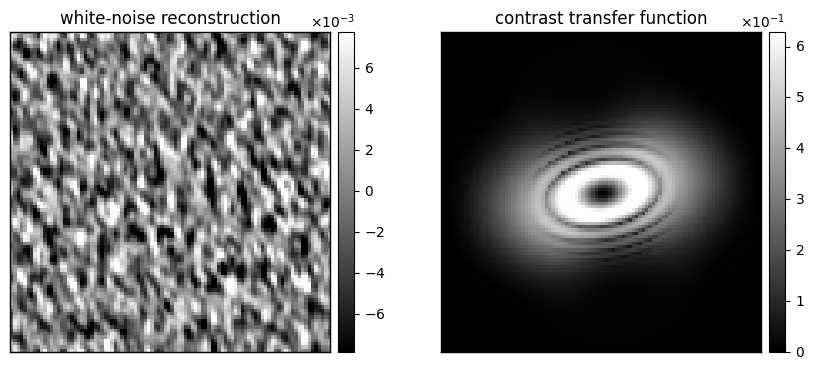

In [138]:
# least squares fit recursive
direct_ptycho = direct_ptycho.fit_hyperparameters_least_squares(
    aberration_coefs = {"C10":0,"C12":0,"phi12":0}, # no prior guess
    cartesian_basis=[["C10"],["C10"],["C10"],["C10","C12_a","C12_b"]],
    q_signal_weight=0.25,
    verbose=True,
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

Finally, although this dataset doesn't have any higher orders, we can fit higher-order coefficients.

The order in which these get fitted is controlled by `fit_method`:
- `fit_method="global"`:  
  Fit all specified aberrations in a single solve.

Fitting aberrations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77order/s, ['C10', 'C12_a', 'C12_b', 'C21_a', 'C21_b', 'C30']]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 177.62168884277344, 'C12': 98.00218963623047, 'phi12': 0.14575737714767456, 'C21': 1.178038239479065, 'phi21': -1.5555285215377808, 'C30': 0.12523530423641205},
)


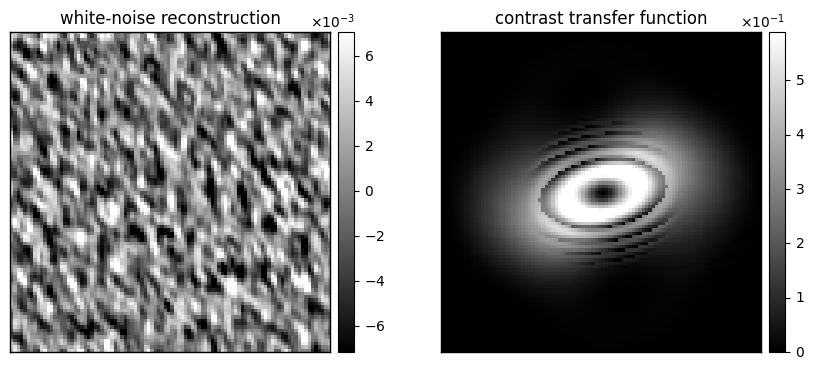

In [144]:
# least squares fit recursive
direct_ptycho = direct_ptycho.fit_hyperparameters_least_squares(
    aberration_coefs = {"C10":0,"C12":0,"phi12":0}, # no prior guess
    cartesian_basis="low_order",
    fit_method="global",
    num_q_modes=12,
    q_signal_weight=0.25,
    verbose=True,
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

- `fit_method="recursive"`:  
  Fit aberrations in cumulative rounds of increasing radial order.  
  Example:
  ```python
  ["C10", "C12_a", "C12_b", "C21_a", "C21_b"]
  ```
  → two rounds:  
  `["C10", "C12_a", "C12_b"]`, then  
  `["C10", "C12_a", "C12_b", "C21_a", "C21_b"]`.

Fitting aberrations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81order/s, ['C10', 'C12_a', 'C12_b', 'C21_a', 'C21_b', 'C30']]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 182.1570587158203, 'C12': 98.34085845947266, 'phi12': 0.144149050116539, 'C21': 1.484663486480713, 'phi21': -1.5593923330307007, 'C30': 0.15808582305908203},
)


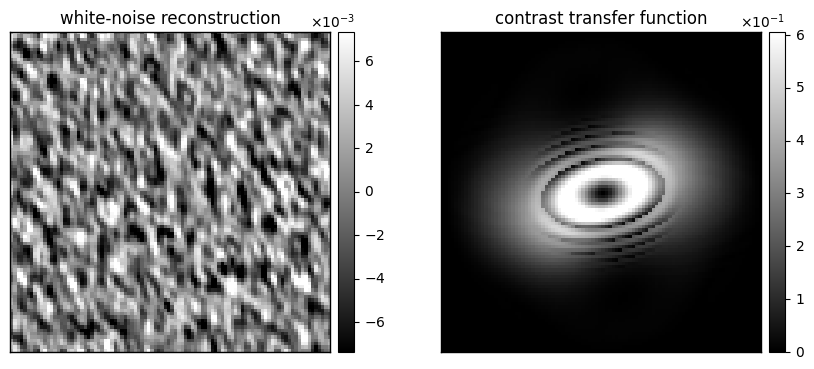

In [145]:
# least squares fit recursive
direct_ptycho = direct_ptycho.fit_hyperparameters_least_squares(
    aberration_coefs = {"C10":0,"C12":0,"phi12":0}, # no prior guess
    cartesian_basis="low_order",
    fit_method="global",
    num_q_modes=12,
    q_signal_weight=0.25,
    verbose=True,
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);

- `fit_method="sequential"`:  
  Fit aberrations in exclusive rounds of increasing radial order.  
  The same list above yields:
  `["C10", "C12_a", "C12_b"]`, then  
  `["C21_a", "C21_b"]`.

Fitting aberrations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77order/s, ['C30']]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 100.0},
  initial_rotation_angle=-0.13962634015954636,
  optimized_aberrations={'C10': 182.15716552734375, 'C12': 98.3408432006836, 'phi12': 0.1441490799188614, 'C21': 1.4846607446670532, 'phi21': -1.5593935251235962, 'C30': 0.15808585286140442},
)


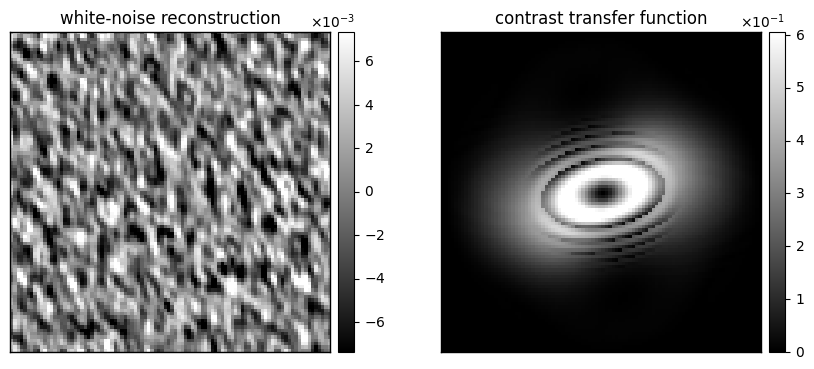

In [146]:
# least squares fit recursive
direct_ptycho = direct_ptycho.fit_hyperparameters_least_squares(
    aberration_coefs = {"C10":0,"C12":0,"phi12":0}, # no prior guess
    cartesian_basis="low_order",
    fit_method="sequential",
    num_q_modes=12,
    q_signal_weight=0.25,
    verbose=True,
)

ssb_guess = direct_ptycho.reconstruct(verbose=False).obj
visualize_recon_and_ctf(ssb_guess);